In [27]:
!pip install --upgrade openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
# Load the required packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [4]:
# Import the housing dataset
from google.colab import files
file = files.upload() 
housing = pd.read_csv("housing.csv")
housing.head()

Saving housing.csv to housing.csv


,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [92]:
housing.describe()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,3.620663,11.350495,11.154257,0.069307,0.554728,6.284059,68.581584,3.794460,9.566337,408.459406,18.461782,356.594376,12.668257,22.529901
std,8.608569,23.343704,6.855868,0.254227,0.115990,0.703195,28.176371,2.107761,8.707553,168.629992,2.162520,91.367787,7.139950,9.205991
min,0.009060,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082210,0.000000,5.190000,0.000000,0.449000,5.885000,45.000000,2.100000,4.000000,279.000000,17.400000,375.330000,7.010000,17.000000
50%,0.259150,0.000000,9.690000,0.000000,0.538000,6.208000,77.700000,3.199200,5.000000,330.000000,19.100000,391.430000,11.380000,21.200000
75%,3.678200,12.500000,18.100000,0.000000,0.624000,6.625000,94.100000,5.211900,24.000000,666.000000,20.200000,396.210000,16.960000,25.000000
max,88.976000,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.127000,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [145]:
class LinearRegression:
    def __init__(self, X,y,learningRate,tolerance,maxIteration,lamda=0.05,batch_size=1,gd=False,reg=False,sgd=False)->None:
        self.X=X
        self.y=y
        self.tolerance=tolerance
        self.learningRate=learningRate
        self.maxIteration=maxIteration
        self.gd=gd
        self.lamda=lamda
        self.reg=reg
        self.sgd=sgd
        self.batch_size=batch_size

    #Splitting the data into test and train data    
    def trainTestSplit(self):
        X_train,X_test,y_train,y_test=train_test_split(self.X,self.y,test_size=0.3,random_state=0)
        return X_train, X_test,y_train,y_test
    
    # Adding column 1 to the matrix at the start 
    def add_X0(self,X):
        return np.column_stack([np.ones([X.shape[0],1]),X]) 
       
    #Normalizing the training data
    def normalize(self,X):
        mean=np.mean(X,0)
        sd=np.std(X,0)

        X_norm=(X-mean)/sd
        X_norm=self.add_X0(X_norm)

        return X_norm, mean, sd
    
    #Normalizing the test data
    def normalizeTestData(self, X, trainMean,trainSd):
        X_norm=(X-trainMean)/trainSd
        X_norm=self.add_X0(X_norm)
        return X_norm
    
    #Closed-form solution can be applicable if and only if the matrix is full-rank and invertible
    #We need to check if the matrix is full rank?
    def rank(self,X,eps=1e-12):
        u,s,vh=np.linalg.svd(X)
     
        return len([x for x in s if abs(x)>eps]) 
    
    # Checking rank of the matrix
    def checkMatrix(self,X):
        X_rank=np.linalg.matrix_rank(X)
        
        if X_rank==min(X.shape[0],X.shape[1]):
            self.fullRank=True
            print("Data is Full Rank")
        else:
            self.fullRank=False
            print("Data is not Full Rank")
            
    # Checking for invertibility of matrix i.e. if the no of dimentions are greater than or less than rows?
    def checkInvertibility(self,X):
        if X.shape[0]<X.shape[1]:
            self.lowRank=True
            print("Data is low Rank")
        else:
            self.lowRank=False
            print("Data is not low Rank")
    
    #Closed form solution
    def closedFormSolution(self,X,y,reg):
        if reg==False:
            w=np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)   
        else:
            w=np.linalg.inv(X.T.dot(X)+ self.lamda*(np.identity(X.shape[1]))).dot(X.T).dot(y)
        return w    
    
    # Gradient Descent method
    def gradientDescent(self,X,y,reg):
        errorSequences=[]
        last=float('inf')                          
        for t in tqdm(range(self.maxIteration)):             
            self.w=self.w-self.learningRate *self.costDerivative(X,y)
            cur=self.sse(X,y)
            diff=last-cur              
            last=cur
            errorSequences.append(cur)
            if abs(diff)< self.tolerance:
                print("The model stopped -no further improvement")
                break
        self.plot(errorSequences)

    
    def stochasticGradientDescent(self,X,y):
        errorSequences=[]
        last=float('inf')                           
        sigma=0.0000001
        tao=0.01
        cur=0
        diff=0
        for t in tqdm(range(self.maxIteration)):             
            
            for i in range(0,X.shape[0],self.batch_size):
                Xk=X[i:i+self.batch_size,:]
                yk=y[i:i+self.batch_size]
                self.w=self.w - (self.learningRate* self.costDerivative(X,y))
            
            cur=self.sse(X,y)
            diff=last-cur              
            last=cur
            errorSequences.append(cur)

            if diff< self.tolerance:
                print("The model stopped -no further improvement")
                self.plot(errorSequences)
                break
        self.plot(errorSequences)

    def plot(self, errorSequences):
        plt.ticklabel_format(style='plain')
        plt.plot(errorSequences)
        plt.xlabel('Number of Iterations')
        plt.ylabel('Sum of Squared Error')
    
    #Sum of squared errors function 
    def sse(self,X,y):
        y_hat=self.predict(X)
        return ((y_hat-y)**2).sum()
    
    #Predict Function
    def predict(self,X):
        return X.dot(self.w) #w is theta
    
    #Cost function
    def costFunction(self,X,y):
        return self.rmse(X,y)/2
    
    def rmse(self,X,y):
        y_hat=self.predict(X)
        return np.sqrt((((y_hat-y)**2)/X.shape[0]).sum())
    
    #Cost Derivatives
    def costDerivative(self,X,y):
        y_hat=self.predict(X)
        if self.reg==False:
            return (y_hat-y).dot(X)
        else:
            return (y_hat-y).dot(X)+(self.lamda * self.w)


    def fitModel(self):
        self.X_train,self.X_test,self.y_train,self.y_test=self.trainTestSplit()
        self.X_train,self.mean,self.sd=self.normalize(self.X_train)
        self.X_test=self.normalizeTestData(self.X_test, self.mean, self.sd)
        
        self.checkMatrix(self.X_train)
        self.checkInvertibility(self.X_train)
        
        if self.fullRank and not self.lowRank and not self.gd and not self.sgd:
            print("Solving using closed form solution")
            self.w=self.closedFormSolution(self.X_train,self.y_train,self.reg)
            
        elif self.gd and not self.sgd:
            print("Solving using gradient descent")
            self.w=np.ones(self.X_train.shape[1],dtype=np.float64)*0
            self.gradientDescent(self.X_train,self.y_train,self.reg)
        else:
            print("Solving using stochastic gradient descent")
            self.w=np.ones(self.X_train.shape[1],dtype=np.float64)*0
            self.stochasticGradientDescent(self.X_train,self.y_train)
        print()
        print("Weights: "+str(self.w))
        print("Errors in train dataset:")
        print()
        print("RMSE: "+str(self.rmse(self.X_train,self.y_train)))
        print("SSE: "+str(self.sse(self.X_train,self.y_train)))
        print()
        print("Errors in test dataset:")
        print("RMSE: "+str(self.rmse(self.X_test,self.y_test)))
        print("SSE: "+str(self.sse(self.X_test,self.y_test)))
        

### **HOUSING**

In [149]:
#Closed Form Solution without Regularization
regression=LinearRegression(housing.values[:,0:-1],housing.values[:,-1],
                            learningRate=0.0004, tolerance=0.005, maxIteration=50000,gd=False,reg=False,sgd=False)
regression.fitModel()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [22.93399433 -0.90751811  1.04796575  0.38867104  0.6622465  -2.17214484
  2.58716716  0.50645061 -2.59559964  2.30818886 -1.67320027 -2.33651383
  0.65618617 -3.99472177]
Errors in train dataset:

RMSE: 4.731796522403048
SSE: 7903.63411028723

Errors in test dataset:
RMSE: 4.624025082730341
SSE: 3250.0044107893395


In [151]:
#Closed Form Solution With Regularization
regression=LinearRegression(housing.values[:,0:-1],housing.values[:,-1],
                            learningRate=0.0004, tolerance=0.005, maxIteration=50000,lamda=0.05,gd=False,reg=True,sgd=False)
regression.fitModel()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [22.93074635 -0.90704836  1.04703889  0.38702146  0.6624847  -2.1699506
  2.58783236  0.50540804 -2.59424036  2.30370477 -1.66923307 -2.33589141
  0.65613963 -3.99356316]
Errors in train dataset:

RMSE: 4.731798116592567
SSE: 7903.639435914704

Errors in test dataset:
RMSE: 4.62398487366843
SSE: 3249.9478890109967


Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 356/50000 [00:00<00:06, 7173.61it/s]

The model stopped -no further improvement

Weights: [22.93399433 -0.90293476  1.03869262  0.36249203  0.66589525 -2.16437442
  2.59214504  0.49773684 -2.59871216  2.24055986 -1.59781715 -2.33365665
  0.65569719 -3.99179609]
Errors in train dataset:

RMSE: 4.731875211402964
SSE: 7903.896984750314

Errors in test dataset:
RMSE: 4.6253969322012605
SSE: 3251.9331106233585


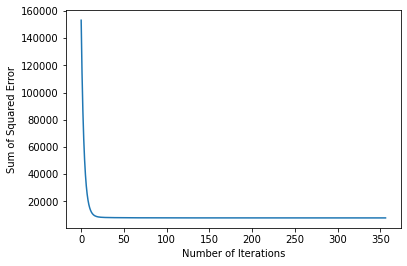

In [153]:
#Gradient Descent Solution without Regularization
regression1=LinearRegression(housing.values[:,0:-1],housing.values[:,-1], learningRate=0.0004,
                            tolerance=0.005, maxIteration=50000,gd=True,reg=False,sgd=False)
regression1.fitModel()

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 359/50000 [00:00<00:03, 14543.86it/s]

The model stopped -no further improvement

Weights: [22.93074635 -0.90263531  1.03810827  0.3618095   0.6659988  -2.1624825
  2.59262225  0.49702347 -2.59724226  2.23857228 -1.59662445 -2.33314421
  0.65566852 -3.99074905]
Errors in train dataset:

RMSE: 4.731880395303458
SSE: 7903.914302636393

Errors in test dataset:
RMSE: 4.625311586518929
SSE: 3251.8131054027112


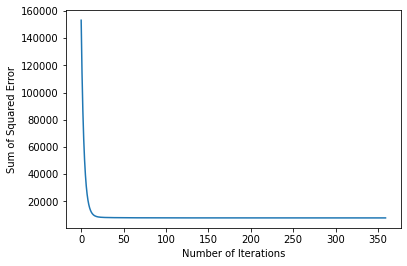

In [155]:
#Gradient Descent Solution with Regularization
regression2=LinearRegression(housing.values[:,0:-1],housing.values[:,-1],learningRate=0.0004,
                            tolerance=0.005, maxIteration=50000,lamda=0.05,gd=True,reg=True,sgd=False)
regression2.fitModel()

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 2/50000 [00:00<28:38, 29.09it/s]

The model stopped -no further improvement

Weights: [22.93074635 -0.90704226  1.04702648  0.38698647  0.66248958 -2.16994072
  2.58783888  0.50539665 -2.59424463  2.30361427 -1.66913192 -2.33588774
  0.65613897 -3.99355938]
Errors in train dataset:

RMSE: 4.731798129591283
SSE: 7903.639479338856

Errors in test dataset:
RMSE: 4.623986668629091
SSE: 3249.950412172254


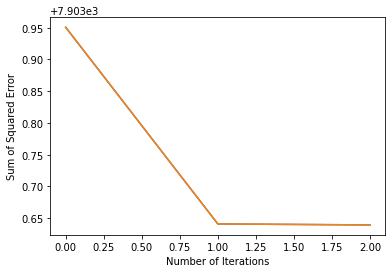

In [158]:
#Stochastic Gradient Descent
regression3=LinearRegression(housing.values[:,0:-1],housing.values[:,-1], learningRate=0.0004,
                            tolerance=0.005, maxIteration=50000,lamda=0.05,gd=False,reg=True,sgd=True)
regression3.fitModel()

### **YACHT**

In [162]:
# Import the housing dataset
from google.colab import files
file = files.upload() 
yacht = pd.read_csv("yachtData.csv")
yacht.head()

Saving yachtData.csv to yachtData (2).csv


,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82


In [163]:
yacht.describe()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
count,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000
mean,-2.382085,0.564124,4.788664,3.936645,3.206938,0.288029,10.529186
std,1.515682,0.023327,0.253470,0.549080,0.248394,0.100678,15.173594
min,-5.000000,0.530000,4.340000,2.810000,2.730000,0.125000,0.010000
25%,-2.400000,0.546000,4.770000,3.750000,3.150000,0.200000,0.780000
50%,-2.300000,0.565000,4.780000,3.950000,3.150000,0.300000,3.090000
75%,-2.300000,0.574000,5.100000,4.170000,3.510000,0.375000,12.830000
max,0.000000,0.600000,5.140000,5.350000,3.640000,0.450000,62.420000


In [164]:
#Closed Form Solution without Regularization
regression=LinearRegression(yacht.values[:,0:-1],yacht.values[:,-1],
                            learningRate=0.0004, tolerance=0.005, maxIteration=50000,gd=False,reg=False,sgd=False)
regression.fitModel()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [10.74271028  0.54271589 -0.48644592  0.53145418 -0.58852203 -0.84401335
 12.89451446]
Errors in train dataset:

RMSE: 8.83244987355699
SSE: 16694.604544543934

Errors in test dataset:
RMSE: 9.051378846467502
SSE: 7619.25368907198


In [166]:
#Closed Form Solution With Regularization
regression=LinearRegression(yacht.values[:,0:-1],yacht.values[:,-1],
                            learningRate=0.0004, tolerance=0.005, maxIteration=50000,lamda=0.05,gd=False,reg=True,sgd=False)
regression.fitModel()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [10.74020089  0.54248101 -0.49190563  0.50883553 -0.57008803 -0.82226811
 12.89136527]
Errors in train dataset:

RMSE: 8.832451260873194
SSE: 16694.6097889999

Errors in test dataset:
RMSE: 9.05044349702902
SSE: 7617.679056841085


Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 558/50000 [00:00<00:02, 22398.31it/s]

The model stopped -no further improvement

Weights: [10.74271028  0.54013899 -0.561333    0.23019536 -0.34306019 -0.55487531
 12.89266347]
Errors in train dataset:

RMSE: 8.83254134600103
SSE: 16694.95033856699

Errors in test dataset:
RMSE: 9.052068542976757
SSE: 7620.414876327688


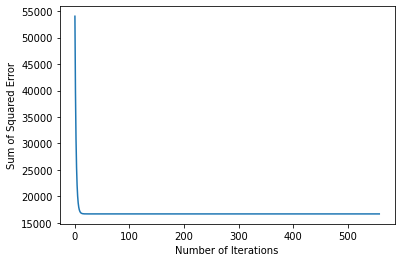

In [167]:
#Gradient Descent Solution without Regularization
regression2_yacht=LinearRegression(yacht.values[:,0:-1],yacht.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,gd=True,reg=False,sgd=False)
regression2_yacht.fitModel()

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  0%|          | 131/50000 [00:00<00:05, 9475.14it/s]

The model stopped -no further improvement

Weights: [10.263125    0.52890271 -0.60620791 -0.07489317 -0.09339158 -0.25487309
 12.31549818]
Errors in train dataset:

RMSE: 8.864592068247488
SSE: 16816.332402797365

Errors in test dataset:
RMSE: 8.896537053329496
SSE: 7360.798553337615


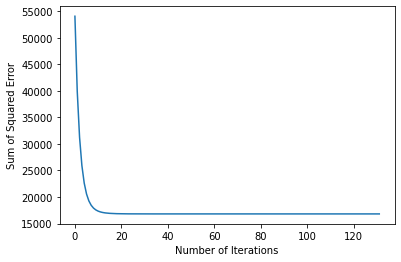

In [168]:
#Gradient Descent Solution with Regularization
regression2_yacht=LinearRegression(yacht.values[:,0:-1],yacht.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,lamda=10,gd=True,reg=True,sgd=False)
regression2_yacht.fitModel()

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 11/50000 [00:00<05:33, 149.78it/s]

The model stopped -no further improvement

Weights: [10.74271028  0.54257323 -0.49059154  0.51477699 -0.57493367 -0.82800715
 12.89441199]
Errors in train dataset:

RMSE: 8.832450153879812
SSE: 16694.605604245102

Errors in test dataset:
RMSE: 9.051410529840105
SSE: 7619.307029912132


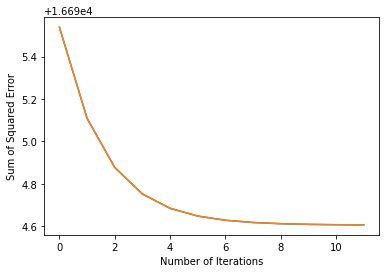

In [169]:
#Stochastic Gradient Descent Solution without Regularization
regression3_yacht=LinearRegression(yacht.values[:,0:-1],yacht.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,gd=False,reg=False,sgd=True)
regression3_yacht.fitModel()

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 12/50000 [00:00<06:09, 135.24it/s]

The model stopped -no further improvement

Weights: [10.69274419  0.53951811 -0.55196179  0.25485663 -0.36305986 -0.57781324
 12.83287675]
Errors in train dataset:

RMSE: 8.832872525717523
SSE: 16696.20232989315

Errors in test dataset:
RMSE: 9.032851848527175
SSE: 7588.094364121996


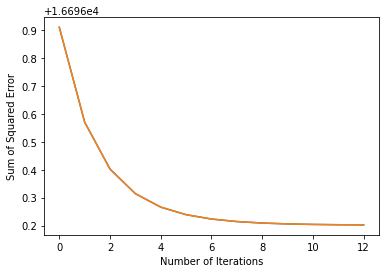

In [170]:
#Stochastic Gradient Descent Solution with Regularization
regression3_yacht=LinearRegression(yacht.values[:,0:-1],yacht.values[:,-1],
                            learningRate=0.001,
                            tolerance=0.001, maxIteration=50000,lamda=1,gd=False,reg=True,sgd=True)
regression3_yacht.fitModel()

### **CONCRETE**

In [172]:
# Import the housing dataset
from google.colab import files
file = files.upload() 
concrete = pd.read_csv("concreteData.csv")
concrete.head()

Saving concreteData.csv to concreteData.csv


,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


In [174]:
concrete.describe()

,540,0,0.1,162,2.5,1040,676,28,79.99
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,280.916327,73.967638,54.241011,181.586297,6.208260,972.853741,773.675316,45.679300,35.775034
std,104.244768,86.290493,64.005792,21.355876,5.975628,77.763596,80.157154,63.198226,16.656933
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.000000,0.000000,0.000000,164.900000,0.000000,932.000000,732.600000,7.000000,23.700000
50%,272.800000,22.000000,0.000000,185.000000,6.400000,968.000000,779.700000,28.000000,34.400000
75%,350.000000,143.000000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,45.940000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [176]:
#Closed Form Solution without Regularization
regression1_conrete=LinearRegression(concrete.values[:,0:-1],concrete.values[:,-1],learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,gd=False,reg=False,sgd=False)
regression1_conrete.fitModel()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [35.55869444 13.07061719  9.29612788  6.07754028 -2.38797659  2.13444427
  1.74782814  1.75752107  7.36636378]
Errors in train dataset:

RMSE: 10.041854635012676
SSE: 72603.96804772239

Errors in test dataset:
RMSE: 11.106342967100197
SSE: 38115.413917782505


In [177]:
#Closed Form Solution With Regularization
regression1_conrete=LinearRegression(concrete.values[:,0:-1],concrete.values[:,-1],learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,lamda=5,gd=False,reg=True,sgd=False)
regression1_conrete.fitModel()

Data is Full Rank
Data is not low Rank
Solving using closed form solution

Weights: [35.31346207 11.93611046  8.15994274  5.07161968 -3.12597866  2.14843617
  0.98630262  0.76779464  7.26713929]
Errors in train dataset:

RMSE: 10.054456966363253
SSE: 72786.3155196844

Errors in test dataset:
RMSE: 11.096146519828066
SSE: 38045.460485153184


Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 443/50000 [00:00<00:01, 25025.28it/s]

The model stopped -no further improvement

Weights: [35.55869444 13.06540412  9.29085934  6.07298081 -2.39238759  2.13389392
  1.74374962  1.75244069  7.36620932]
Errors in train dataset:

RMSE: 10.041854848466567
SSE: 72603.97113432348

Errors in test dataset:
RMSE: 11.106279311277472
SSE: 38114.977003294


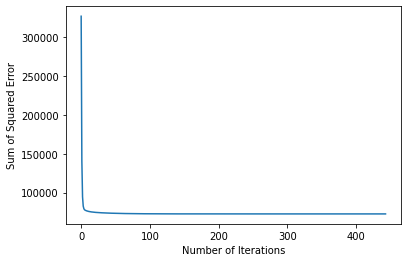

In [178]:
#Gradient Descent Solution without Regularization
regression2_conrete=LinearRegression(concrete.values[:,0:-1],concrete.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,gd=True,reg=False,sgd=False)
regression2_conrete.fitModel()

Data is Full Rank
Data is not low Rank
Solving using gradient descent


  1%|          | 559/50000 [00:00<00:02, 17735.37it/s]

The model stopped -no further improvement

Weights: [35.07158904 11.1311055   7.35680075  4.35647911 -3.59797833  2.18586962
  0.47508292  0.09408741  7.17942276]
Errors in train dataset:

RMSE: 10.081936489092215
SSE: 73184.71922646412

Errors in test dataset:
RMSE: 11.102386609617483
SSE: 38088.2634246888


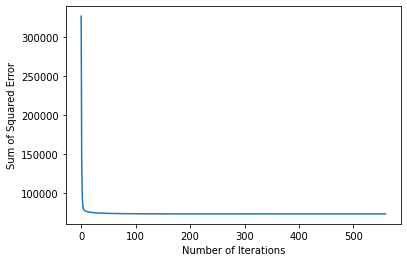

In [179]:
#Gradient Descent Solution with Regularization
regression2_conrete=LinearRegression(concrete.values[:,0:-1],concrete.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,lamda=10,gd=True,reg=True,sgd=False)
regression2_conrete.fitModel()

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 2/50000 [00:00<47:57, 17.38it/s]

The model stopped -no further improvement

Weights: [35.55869444 13.07061719  9.29612788  6.07754028 -2.38797659  2.13444427
  1.74782814  1.75752107  7.36636378]
Errors in train dataset:

RMSE: 10.041854635012676
SSE: 72603.9680477224

Errors in test dataset:
RMSE: 11.106342967100199
SSE: 38115.41391778252


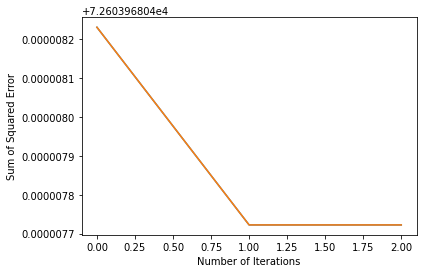

In [180]:
#Stochastic Gradient Descent Without Regularization
regression3_conrete=LinearRegression(concrete.values[:,0:-1],concrete.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0000001, maxIteration=50000,gd=False,reg=False,sgd=True)
regression3_conrete.fitModel()

Data is Full Rank
Data is not low Rank
Solving using stochastic gradient descent


  0%|          | 2/50000 [00:00<27:07, 30.73it/s]

The model stopped -no further improvement

Weights: [35.07158904 11.13111611  7.35681148  4.35648839 -3.59796935  2.18587074
  0.47509122  0.09409775  7.17942308]
Errors in train dataset:

RMSE: 10.081936193307401
SSE: 73184.71493226365

Errors in test dataset:
RMSE: 11.102386511171705
SSE: 38088.26274922525


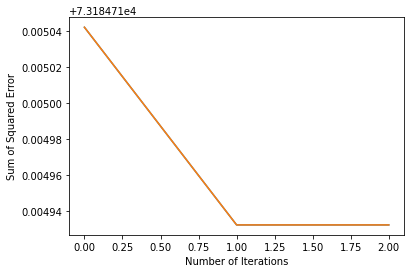

In [181]:
#Stochastic Gradient Descent With Regularization
regression3_conrete=LinearRegression(concrete.values[:,0:-1],concrete.values[:,-1],
                            learningRate=0.0007,
                            tolerance=0.0001, maxIteration=50000,lamda=10,gd=False,reg=True,sgd=True)
regression3_conrete.fitModel()